import os
import json
for file in os.listdir("./imageLabel/."):
    if(file.endswith(")")):
        #data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
        if os.path.isfile('./imageLabel/' + file + "/data_file.json"):
            data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
            #data["folder_location"] = os.getcwd() + '/imageLabel/' + file
            data["folder_location"] = '/Users/lechn/Desktop/jasonTab/' + file
            data["image_location"] = '/Users/lechn/Desktop/miniset/' + file + ".jpg"
            with open('./imageLabel/' + file + "/data_file.json", "w") as write_file:
                json.dump(data, write_file)

In [1]:
import pandas as pd
import tensorflow as tf
import sys
print(sys.version)
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy
from ipywidgets import interact, widgets
from scipy import stats
import seaborn as sns
import os
import json
from pprint import pprint
import cv2

3.6.5 (default, Jun 17 2018, 12:13:06) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]


Using TensorFlow backend.


In [76]:
numGrids = 12
features = []
y = []
for file in os.listdir("./imageLabel/."):
    if(file.startswith("A")):
        file = "A (101)"
        print("Extracting labels from file " + file)
        img = cv2.imread("../../imagesDataset/" + file + ".jpg")
        height, width, channels = img.shape
        gheight, gwidth = int(height/numGrids) , int(width/numGrids)
        for index in range(numGrids**2):
            rowIndex = index % numGrids
            colIndex = int(index / numGrids)
            grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth, :]
            blur = cv2.resize(img, (256, 256))

            #feature extraction
            featureList = []
            gridRed = grid[:,:,0]
            gridGreen = grid[:,:,1]
            gridBlue = grid[:,:,2]
            rbar = np.average(gridRed)
            gbar = np.average(gridGreen)
            bbar = np.average(gridBlue)
            featureList.append(rbar)
            featureList.append(gbar)
            featureList.append(bbar)
            featureList += np.bincount(np.ravel((gridRed/32).astype(int)), minlength = 8).tolist()
            featureList += np.bincount(np.ravel((gridGreen/32).astype(int)), minlength = 8).tolist()
            featureList += np.bincount(np.ravel((gridBlue/32).astype(int)), minlength = 8).tolist()
            width, height, dimension = grid.shape
            f = np.fft.fft2(grid)
            fshift = np.fft.fftshift(f)
            magnitude_spectrum = np.abs(20*np.log(np.abs(fshift + 0.00001)))
            featureList += np.average(np.average(magnitude_spectrum,axis = 0), axis = 0).tolist()
            featureList += [index]
            features.append(featureList)

    #one image
    break
                    
                
features = np.asarray(features)
#features = features / features.max(axis=0)
print("Features shape", features.shape, " label shape", len(y))  

Extracting labels from file A (101)
Features shape (144, 31)  label shape 0


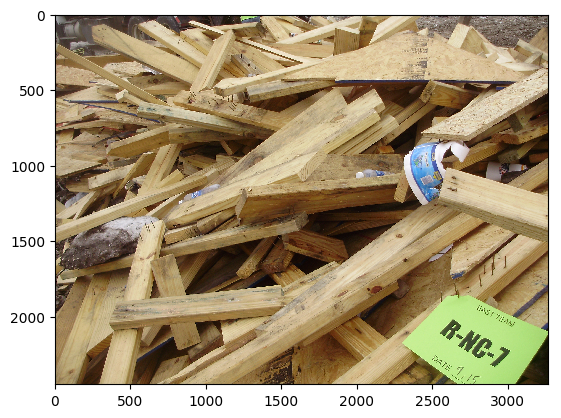

In [77]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [78]:
from keras.models import load_model
model = load_model('model.h5py')

In [79]:
k = model.predict_classes(features)
jobs = list(set(k))
counts = [list(k).count(job) for job in jobs]
import pickle
pickle_in = open("dict.pickle","rb")
reverseDic = pickle.load(pickle_in)
pickle_in.close()
if jobs[0] in reverseDic:
    jobs = [reverseDic[job] for job in jobs]
print(jobs)
print(counts)
print(reverseDic)

['Roofing', 'Wood', 'Plastic']
[1, 138, 5]
{0: 'Roofing', 1: 'Organics', 2: 'Concrete', 3: 'Bricks', 4: 'Other', 5: 'Wood', 6: 'Plastic', 7: 'Gypsum', 8: 'Metal'}


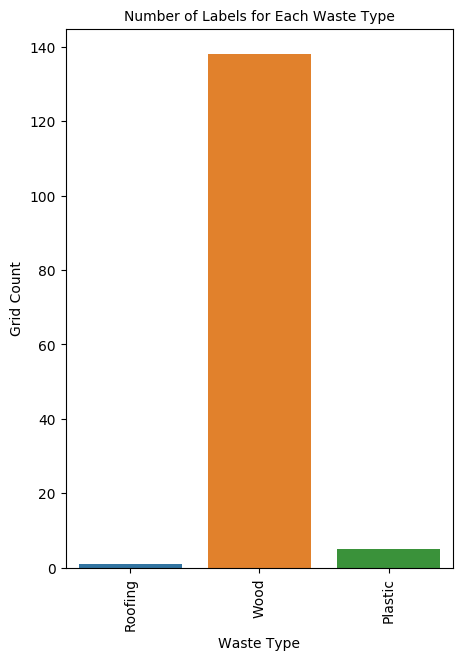

In [80]:
f, ax = plt.subplots(figsize=(5, 7))
plt.xticks(rotation='90')
sns.barplot(x=jobs, y=counts)
plt.xlabel('Waste Type', fontsize=10)
plt.ylabel('Grid Count', fontsize=10)
plt.title('Number of Labels for Each Waste Type', fontsize=10)
plt.savefig('result.jpg')

In [81]:
dicMaterial = {}

In [82]:
width, height, _ = img.shape
gridW, gridH = int(width/numGrids), int(height/numGrids)
for mater in reverseDic.values():
    mIcon = cv2.imread("./icon/" + mater + ".png")
    mIcon = cv2.cvtColor(mIcon, cv2.COLOR_BGR2RGB)
    mIcon = cv2.resize(mIcon, (gridH, gridW))
    dicMaterial[mater] = mIcon/255.

print(dicMaterial.keys())

dict_keys(['Roofing', 'Organics', 'Concrete', 'Bricks', 'Other', 'Wood', 'Plastic', 'Gypsum', 'Metal'])


In [124]:
sns.reset_orig()

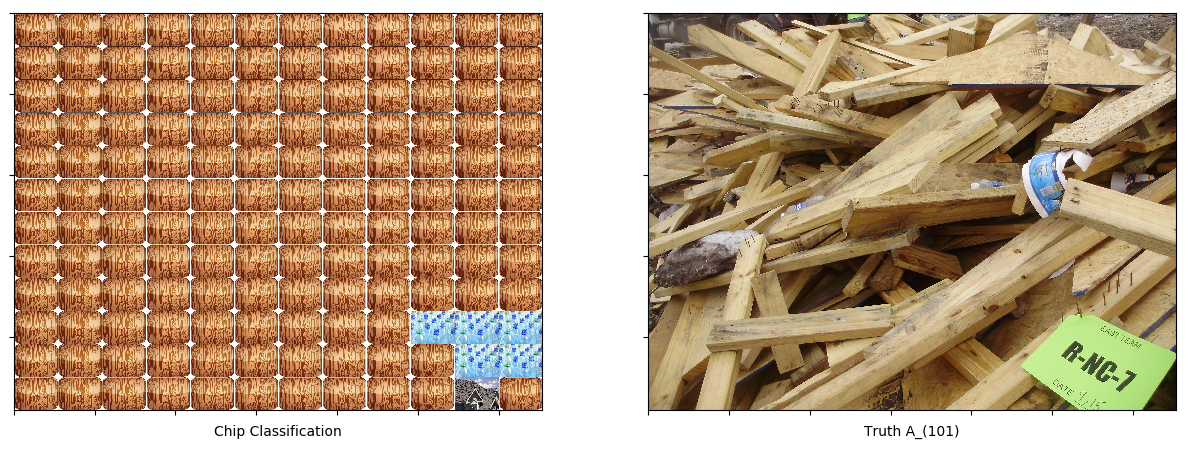

In [137]:
predictImg = np.zeros(img.shape)
count = 0
for i in range(0, img.shape[0], gridW):
    for j in range(0, img.shape[1], gridH):
        material = reverseDic[k[count]]
        if material in dicMaterial:
            predictImg[i:i + gridW, j:j + gridH, :] = dicMaterial[material]
        else:
            predictImg[i:i + gridW, j:j + gridH, :] = 0
        count += 1

font = 15
f, ax = plt.subplots(1,2,figsize=(font, 4*font//5))
for i in range(len(ax)):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
ax[0].imshow(predictImg)
ax[0].set(xlabel='Chip Classification')
ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
file = file.replace(" ", "_")
ax[1].set(xlabel='Truth ' + str(file))
# f.suptitle('Chip Classification for file ' + file, fontsize=font)
f.savefig("img/" + str(file) + '.png')

import os
import json
for file in os.listdir("./imageLabel/."):
    if(file.startswith("A")):
        #data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
        if os.path.isfile('./imageLabel/' + file + "/data_file.json"):
            data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
            #data["folder_location"] = os.getcwd() + '/imageLabel/' + file
            if 'labels' in data:
                for i,label in enumerate(data['labels']):
                    if label == 'Other Materials':
                        data['labels'][i] = 'Other'
                print(set(data['labels']))
            with open('./imageLabel/' + file + "/data_file.json", "w") as write_file:
                json.dump(data, write_file)